# 1 Exploring the Data

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
print (digits.keys())
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


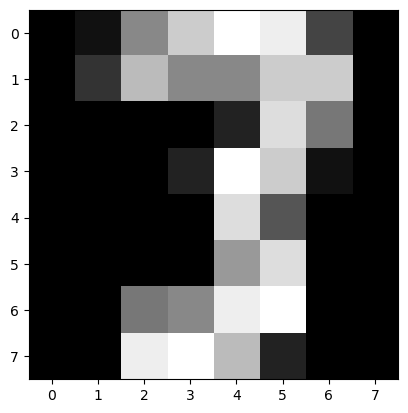

In [4]:
import numpy as np
import matplotlib . pyplot as plt
is_3 = target == 3
img = data[is_3][2].reshape(8, 8) # Reshape the data to 8x8 image
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest") # also try interpolation="bicubic"
plt.show()

In [31]:
from sklearn import model_selection

# Filter dataset to only include digits 3 and 9
is_3_or_9 = np.logical_or(target == 3, target == 9)
data_3_or_9 = data[is_3_or_9]
target_3_or_9 = target[is_3_or_9]

X_all = data_3_or_9
y_all = target_3_or_9
X_train , X_test , y_train , y_test =\
model_selection.train_test_split (X_all, y_all,
test_size = 0.4, random_state = 0)

# 2 Handcrafted Classifier

In [6]:
# Calculate mean images for digits 3 and 9
mean_3 = np.mean(data_3_or_9[target_3_or_9 == 3], axis=0)
mean_9 = np.mean(data_3_or_9[target_3_or_9 == 9], axis=0)

# Calculate pixel differences between mean images
pixel_diffs = np.abs(mean_3 - mean_9)

# Sort pixel differences in descending order and get indices of top k pixels
k = 5
top_k_indices = np.argsort(pixel_diffs)[::-1][:k]

# Print indices and corresponding differences for top k pixels
for i, idx in enumerate(top_k_indices):
    print(f"Pixel {i+1}: Index {idx}, Difference {pixel_diffs[idx]}")

Pixel 1: Index 26, Difference 8.957650273224044
Pixel 2: Index 18, Difference 8.795081967213115
Pixel 3: Index 29, Difference 8.454553734061932
Pixel 4: Index 36, Difference 6.954735883424408
Pixel 5: Index 21, Difference 4.788706739526411


In [7]:
def features2d(X):
    # Define indices of two pixels that seem to distinguish between 3's and 9's
    pixel1_idx = 26
    pixel2_idx = 18
    
    # Extract pixel values for the two chosen pixels
    pixel1 = X[:, pixel1_idx]
    pixel2 = X[:, pixel2_idx]
    
    # Construct 2-dimensional feature space using a linear combination of the two pixels
    features = np.stack([pixel1, pixel2], axis=1)
    
    return features

In [8]:
print(features2d(X_train))

[[11. 16.]
 [16. 10.]
 [ 4. 10.]
 ...
 [ 1.  7.]
 [ 3.  2.]
 [11. 11.]]


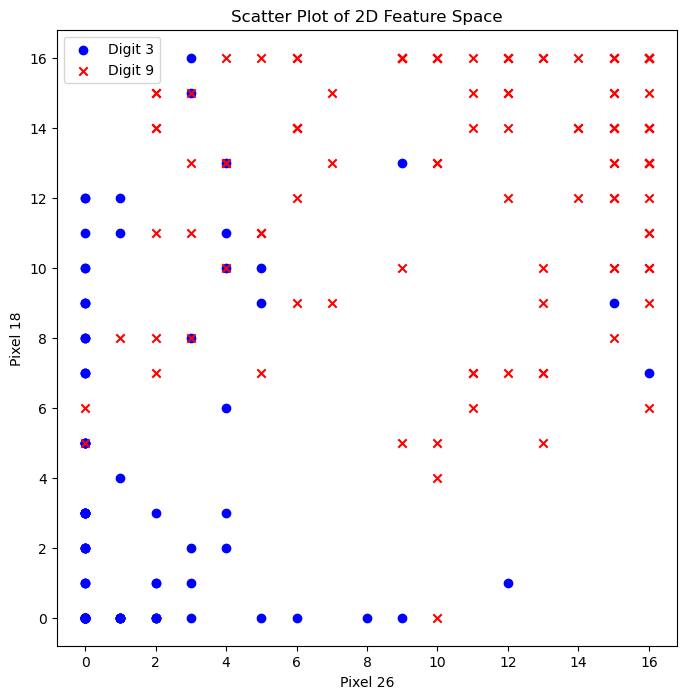

In [9]:
# Extract 2D features from training set
X_train_2d = features2d(X_train)

# Create scatter plot of 2D feature space
plt.figure(figsize=(8, 8))
plt.scatter(X_train_2d[y_train == 3, 0], X_train_2d[y_train == 3, 1], c='b', marker='o', label='Digit 3')
plt.scatter(X_train_2d[y_train == 9, 0], X_train_2d[y_train == 9, 1], c='r', marker='x', label='Digit 9')
plt.title('Scatter Plot of 2D Feature Space')
plt.xlabel('Pixel 26')
plt.ylabel('Pixel 18')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score

def nearest_mean(training_features, training_labels, test_features):
    mean_3 = np.mean(training_features[training_labels == -1], axis=0)
    mean_9 = np.mean(training_features[training_labels == 1], axis=0)

    def dist(x, y):
        return np.sum((x - y) ** 2)

    predicted_labels = []
    for i in range(len(test_features)):
        dist_3 = dist(test_features[i], mean_3)
        dist_9 = dist(test_features[i], mean_9)
        if dist_3 < dist_9:
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)

    return np.array(predicted_labels)


y_train_new = np.where(y_train == 3, -1, 1) # Convert 3's to -1's and 9's to 1's
y_test_new = np.where(y_test == 3, -1, 1) # Convert 3's to -1's and 9's to 1's

# Compute training error
train_preds = nearest_mean(X_train_2d, y_train_new, X_train_2d)
train_acc = accuracy_score(y_train_new, train_preds)

# Compute test error
X_test_2d = features2d(X_test)
test_preds = nearest_mean(X_train_2d, y_train_new, X_test_2d)
test_acc = accuracy_score(y_test_new, test_preds)

print('Training error:', 1 - train_acc)
print('Test error:', 1 - test_acc)

Training error: 0.23283858998144713
Test error: 0.22531293463143254


In [23]:
# Create a grid of points to represent the feature space
x_min, x_max = np.min(X_train[:, 0]), np.max(X_train[:, 0])
y_min, y_max = np.min(X_train[:, 1]), np.max(X_train[:, 1])
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Compute the predicted labels for each point in the grid
nearest_mean_preds = nearest_mean(X_train, y_train, grid_points)
lin_preds = linear_classifier(X_train, y_train, grid_points)

# Reshape the predictions into an image
nearest_mean_img = nearest_mean_preds.reshape(xx.shape)
lin_img = lin_preds.reshape(xx.shape)

# Plot the decision regions
plt.figure(figsize=(12, 8))
plt.imshow(nearest_mean_img, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.4)
plt.imshow(lin_img, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.4)

# Plot the class means and test data
plt.scatter(X_test[y_test==-1, 0], X_test[y_test==-1, 1], c='blue', marker='o', label='Digit 3 (test data)')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='red', marker='s', label='Digit 9 (test data)')
plt.scatter(X_train[y_train==-1, 0], X_train[y_train==-1, 1], c='blue', marker='o', s=200, label='Digit 3 (training data)')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='s', s=200, label='Digit 9 (training data)')

# Plot the decision boundaries
plot_boundary(X_train, y_train, nearest_mean, label='Nearest Mean')
plot_boundary(X_train, y_train, linear_classifier, label='Linear Classifier')

plt.title('Decision Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()


ValueError: operands could not be broadcast together with shapes (2,) (64,) 

In [22]:
def plot_boundary(X, y, clf, label=None):
    x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
    y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    preds = clf(X, y, grid_points)
    img = preds.reshape(xx.shape)
    plt.contour(xx, yy, img, levels=[0], colors='k', linestyles='--', label=label)


# 3 LDA

### 3.1 Implement LDA training

In [1]:
def fit_lda(training_features, training_labels):
    unique_labels = np.unique(training_labels)
    num_classes = len(unique_labels)
    num_features = training_features.shape[1]
    
    mu = np.zeros((num_classes, num_features))
    covmat = np.zeros((num_features, num_features))
    p = np.zeros(num_classes)
    
    for i, label in enumerate(unique_labels):
        # get all instances with the current label
        label_indices = np.where(training_labels == label)[0]
        num_instances = len(label_indices)
        p[i] = num_instances / len(training_labels)
        
        # compute class mean
        mu[i] = np.mean(training_features[label_indices], axis=0)
        
        # compute class covariance matrix
        covmat += np.cov(training_features[label_indices].T) * (num_instances - 1)
        
    # divide by the total number of instances to get the covariance matrix
    covmat /= len(training_labels)
    
    return mu, covmat, p

In [23]:
# Apply fit function to feature data from task 2
mu_2d, covmat_2d, p_2d = fit_lda(X_train_2d, y_train_new)
print(mu_2d)
print(covmat_2d)
print(p_2d)

[[ 1.37168142  3.13274336]
 [ 9.86010363 10.47046632]]
[[32.43460424 15.92851367]
 [15.92851367 27.27775245]]
[0.10482375 0.89517625]


In [32]:
# Apply fit function to full vector of 64 pixels
mu_full, covmat_full, p_full = fit_lda(X_train, y_train)
print(mu_full.shape)
print(covmat_full.shape)
print(p_full)

(2, 64)
(64, 64)
[0.51152074 0.48847926]


In [34]:
X_train.shape

(217, 64)

In [39]:
variances = np.var(X_train, axis=0)
masked_variances = np.ma.masked_less(variances, 0.001)
X_train(:,masked_variances)


[-- 0.7378793348765121 14.955552252118325 11.575442247658675
 10.937246490687851 25.930854339654708 8.701182866486832
 0.027309987470534574 -- 11.464843169317678 15.322559408779107
 15.464758223788996 17.936630635604924 21.690500966255378
 15.251927201681898 0.08583745673087166 -- 11.755017095287675
 37.56070419843279 26.290683599142017 23.09855804965065 24.59096604302492
 9.072012571938258 0.08218479899764222 -- 3.8616662065450456
 34.47471808702676 24.677228227399176 11.401941005330329
 32.736265369831564 8.755760368663594 -- -- 0.16114166790545473
 12.906793518656226 29.135976555034034 33.6101849688887 19.393149143111934
 11.926224808341647 -- -- 1.9666588799932043 7.816687549109115
 7.515598122703827 24.230372273779427 17.413918324874185 19.16570749007201
 -- -- 3.357132238951775 30.307247977234574 15.575994393595112
 24.697402790460593 20.975599396886693 22.53558155832574
 0.0992588502622692 -- 0.6042600182632869 18.997430397757455
 12.747435706853024 12.405487481152713 25.0503939

# 4

In [26]:
import numpy as np

def fit_svm(training_features, training_labels, learning_rate=0.001, lambda_param=0.1, n_iters=500):
    '''Parameters
    -------------------
    training_features : numpy.ndarray, contains the training data. Each row is a sample, each column a feature
    training_labels : numpy.ndarray, contains the class-label of the training data.
    learning_rate : float, for the gradient decent (def 0.001)
    lambda_param : float, for the cost function for determining the weight vector.
    Greater lambda leads to higher margin of the hyperplane and vice versa. (def 0.1)
    n_iters : int, number of iterations (def 500)
    -------------------
    Return
    -------------------
    Returns w and b, the weight vector and the bias respectively.
    -------------------
    Trains the SVM by finding the optimal values for w and b using gradient decent.
    '''

    label_ = np.where(training_labels <= 0, -1, 1)  # we want the classes to be labeled either 1 or -1
    n_sample, n_features = training_features.shape  # No. of rows = sample size, No. of columns = feature size

    w = np.zeros(n_features)
    b = 0

    for _ in range(n_iters):
        for idx, x_i in enumerate(training_features):
            condition = label_[idx] * (np.dot(x_i, w) - b) >= 1  # the derivative of the cost function
            # depends on this condition
            if condition:
                w -= learning_rate * (2 * lambda_param * w)
            else:
                w -= learning_rate * (2 * lambda_param * w - np.dot(x_i, label_[idx]))
                b -= learning_rate * label_[idx]

    return w, b

def predict_svm(X, w, b):
    '''Parameters
    -------------------
    X : numpy.ndarray, contains the data of the samples for the prediction.
    Each row is a sample, each column a feature.
    w : numpy.ndarray, the weight vector.
    b : float, the bias.
    -------------------
    Return
    -------------------
    Returns a numpy.ndarray containing the labels from the prediction.
    '''
    linear_output = np.dot(X, w) - b
    return np.sign(linear_output)


[0.05636221 0.03786291] -0.6621399999996214


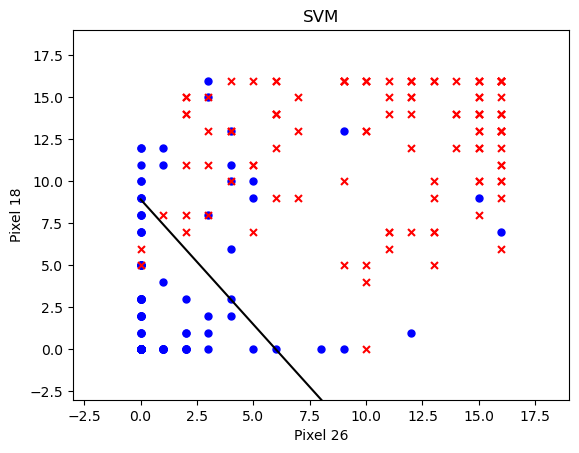

In [43]:
def get_hyperplane_value(x, w, b, offset):   # auxiliary function for visualizing the results
    return (-w[0] * x + b + offset) / w[1]

w, b = fit_svm(X_train_2d, y_train_new, learning_rate=0.00001, lambda_param=0.01, n_iters=1500)
print(w,b)

fig = plt.figure()
aux = fig.add_subplot(1, 1, 1)
plt.scatter(X_train_2d[y_train == 3, 0], X_train_2d[y_train == 3, 1], c='b', marker='o', label='Digit 3', s=25)
plt.scatter(X_train_2d[y_train == 9, 0], X_train_2d[y_train == 9, 1], c='r', marker='x', label='Digit 9', s=25)
plt.xlabel('Pixel 26')
plt.ylabel('Pixel 18')
#plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_new, s=25)
plt.title('SVM')

x0_1 = np.amin(X_train_2d[:, 0])
x0_2 = np.amax(X_train_2d[:, 0])

x1_1 = get_hyperplane_value(x0_1, w, b, 0)
x1_2 = get_hyperplane_value(x0_2, w, b, 0)

x1_1_a = get_hyperplane_value(x0_1, w, b, -1)
x1_2_a = get_hyperplane_value(x0_2, w, b, -1)

x1_1_b = get_hyperplane_value(x0_1, w, b, 1)
x1_2_b = get_hyperplane_value(x0_2, w, b, 1)

aux.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
aux.plot([x0_1, x0_2], [x1_1_a, x1_2_a], 'k')
aux.plot([x0_1, x0_2], [x1_1_b, x1_2_b], 'k')

x1_min = np.amin(X_train_2d[:, 1])
x1_max = np.amax(X_train_2d[:, 1])
aux.set_ylim([x1_min - 3, x1_max + 3])
aux.set_xlim([x0_1 - 3, x0_2 + 3])

plt.show()

Since it is not possible to see how many blue dots and red x are in one spot its is hard to judge the hyperplane. however it is minimizing the red x to be on the "blue dots" side of the hyperplane.

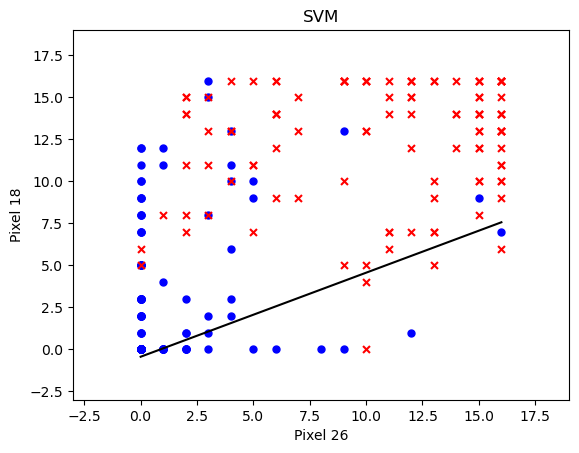

In [44]:
from sklearn.svm import SVC

# train an SVM on the training data
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_2d, y_train_new)

# extract the hyperplane parameters
w = svm.coef_[0]
b = svm.intercept_[0]

fig = plt.figure()
aux = fig.add_subplot(1, 1, 1)
plt.scatter(X_train_2d[y_train == 3, 0], X_train_2d[y_train == 3, 1], c='b', marker='o', label='Digit 3', s=25)
plt.scatter(X_train_2d[y_train == 9, 0], X_train_2d[y_train == 9, 1], c='r', marker='x', label='Digit 9', s=25)
plt.xlabel('Pixel 26')
plt.ylabel('Pixel 18')
#plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_new, s=25)
plt.title('SVM')

x0_1 = np.amin(X_train_2d[:, 0])
x0_2 = np.amax(X_train_2d[:, 0])

x1_1 = get_hyperplane_value(x0_1, w, b, 0)
x1_2 = get_hyperplane_value(x0_2, w, b, 0)

x1_1_a = get_hyperplane_value(x0_1, w, b, -1)
x1_2_a = get_hyperplane_value(x0_2, w, b, -1)

x1_1_b = get_hyperplane_value(x0_1, w, b, 1)
x1_2_b = get_hyperplane_value(x0_2, w, b, 1)

aux.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
aux.plot([x0_1, x0_2], [x1_1_a, x1_2_a], 'k')
aux.plot([x0_1, x0_2], [x1_1_b, x1_2_b], 'k')

x1_min = np.amin(X_train_2d[:, 1])
x1_max = np.amax(X_train_2d[:, 1])
aux.set_ylim([x1_min - 3, x1_max + 3])
aux.set_xlim([x0_1 - 3, x0_2 + 3])

plt.show()

The sklearn classifier does not seem to find a good hyperplane. However it is not finetuned and we can not see how many dots or x are in one spot.

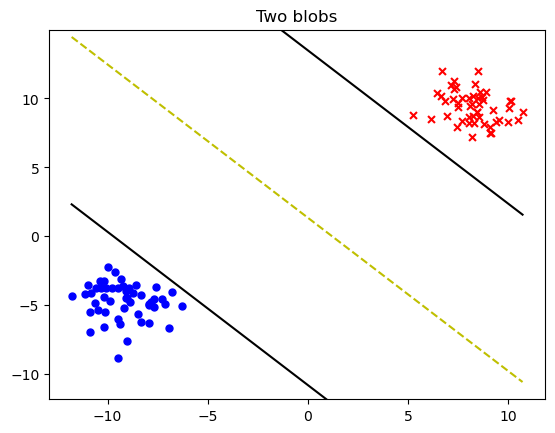

In [55]:
from sklearn.datasets import make_blobs


X, labels = make_blobs(n_features=2, centers=2, cluster_std=1.25, random_state=234)
labels = np.where(labels == 0, -1, 1)

w, b = fit_svm(X, labels)

fig = plt.figure()
aux = fig.add_subplot(1, 1, 1)

plt.scatter(X[labels == -1, 0], X[labels == -1, 1], c='b', marker='o', label='Blob A', s=25)
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], c='r', marker='x', label='Blob B', s=25)
plt.title('Two blobs')

x0_1 = np.amin(X[:, 0])
x0_2 = np.amax(X[:, 0])

x1_1 = get_hyperplane_value(x0_1, w, b, 0)
x1_2 = get_hyperplane_value(x0_2, w, b, 0)

x1_1_a = get_hyperplane_value(x0_1, w, b, -1)
x1_2_a = get_hyperplane_value(x0_2, w, b, -1)

x1_1_b = get_hyperplane_value(x0_1, w, b, 1)
x1_2_b = get_hyperplane_value(x0_2, w, b, 1)

aux.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
aux.plot([x0_1, x0_2], [x1_1_a, x1_2_a], 'k')
aux.plot([x0_1, x0_2], [x1_1_b, x1_2_b], 'k')

x1_min = np.amin(X[:, 1])
x1_max = np.amax(X[:, 1])
aux.set_ylim([x1_min - 3, x1_max + 3])

plt.show()


I was curious as to whether my code actually works, which is why I decided to test it on this simple example and it seems to plot and work correctly.